# Building a GPT - Step by Step

In [1]:
# Download the tiny shakespeare dataset
# !export https_proxy=http://127.0.0.1:7890 http_proxy=http://127.0.0.1:7890 all_proxy=socks5://127.0.0.1:7890
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))  # 总共 1 million 字符

length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# 从 index 到字符的双向映射，属于一种最简单的 tokenizer
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
encode('\n'), decode([0, 1, 2])

([0], '\n !')

In [8]:
# 转到 torch.Tensor
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8
train_data[:block_size+1]  # 之所以 +1，是因为我们要预测下一个字符

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
# 之所以这么处理，是想要 Transformer 可以接收不同长度的输入
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} '{decode(context.tolist())}',".ljust(70), f"the target: {target} '{decode([target.item()])}'")

when input is tensor([18]) 'F',                                        the target: 47 'i'
when input is tensor([18, 47]) 'Fi',                                   the target: 56 'r'
when input is tensor([18, 47, 56]) 'Fir',                              the target: 57 's'
when input is tensor([18, 47, 56, 57]) 'Firs',                         the target: 58 't'
when input is tensor([18, 47, 56, 57, 58]) 'First',                    the target: 1 ' '
when input is tensor([18, 47, 56, 57, 58,  1]) 'First ',               the target: 15 'C'
when input is tensor([18, 47, 56, 57, 58,  1, 15]) 'First C',          the target: 47 'i'
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) 'First Ci',     the target: 58 't'


In [12]:
# （除了时间维度）下一个维度是 batch_size，目的是让 GPU 可以并行处理多个序列（不过这些都是独立计算的）
torch.manual_seed(42)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])  # batch_size x block_size, 每行是一个连续序列
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[57,  1, 46, 47, 57,  1, 50, 53],
        [ 1, 58, 46, 43, 56, 43,  1, 41],
        [17, 26, 15, 17, 10,  0, 32, 53],
        [57, 58,  6,  1, 61, 47, 58, 46]])
targets:
torch.Size([4, 8])
tensor([[ 1, 46, 47, 57,  1, 50, 53, 60],
        [58, 46, 43, 56, 43,  1, 41, 39],
        [26, 15, 17, 10,  0, 32, 53,  1],
        [58,  6,  1, 61, 47, 58, 46,  0]])
----
when input is [57] the target: 1
when input is [57, 1] the target: 46
when input is [57, 1, 46] the target: 47
when input is [57, 1, 46, 47] the target: 57
when input is [57, 1, 46, 47, 57] the target: 1
when input is [57, 1, 46, 47, 57, 1] the target: 50
when input is [57, 1, 46, 47, 57, 1, 50] the target: 53
when input is [57, 1, 46, 47, 57, 1, 50, 53] the target: 60
when input is [1] the target: 58
when input is [1, 58] the target: 46
when input is [1, 58, 46] the target: 43
when input is [1, 58, 46, 43] the target: 56
when input is [1, 58, 46, 43, 56] the target: 43
when input is [1, 58, 46,

## bigram language model

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(42)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)  # 输入一个 index 得到紧跟的下一个 index 的概率（拿出指定的一行）
        # 所谓二元，就是只看前面的这一个字符

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)  batch 4, time 8, channel 65

        if targets is None:  # 为了后文的 generate
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)  # 交叉熵，需要 channel 作为第二个维度（概率分布的这个维度，或者说分类的这个维度）

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)  # 直接 call 会调用 forward
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)  # 这里体现了 bigram 的思想，只看前面的一个字符
            # option1: apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # option2: get the index of the max logit  直接取最大的，而不是从概率分布中采样
            # idx_next = torch.argmax(logits, dim=-1, keepdim=True) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)  # 理论上说随机的 loss 应该是 -ln(1/vocab_size) = -ln(1/65) = 4.17，一般比这个大是因为初始分布不均匀，存在一些熵

input = torch.zeros((2, 1), dtype=torch.long)  # 初始值给 0（换行符）
output = m.generate(idx = input, max_new_tokens=100)
print('\n[Test sequence 1]:', decode(output[0].tolist()), '\n\n[Test sequence 2]:', decode(output[1].tolist()))


torch.Size([32, 65])
tensor(4.8865, grad_fn=<NllLossBackward0>)

[Test sequence 1]: 
o.F&HDmaxDbQk-wj&khBUfW,z3TVMAEfP,coI;$X-J
wnbiPDsntJZyIMYREbt;cQ' COfgxoriPb;3AhkX.E;.MH.SsmWKplfaH 

[Test sequence 2]: 
IqTqasVBi&YRCb  CQ'VIYpDJKh
 .jfTkTGG$qiWkP
gzp?kBu
3bPs:j ,q
oMn:T'dZAsMJjVmccyczJt:ujB?-ejhg-3sB?H


In [14]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [15]:
import time

batch_size = 32
start_time = time.time()

# 转到 GPU (mps) 速度比 CPU 慢一倍...
# device = torch.device('mps')
device = torch.device('cpu')
m = m.to(device)
losses = []

# 非常基本的训练流程
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if steps % 1000 == 0:
        print(f'step {steps}, loss: {loss.item()}')

print('elapsed', time.time() - start_time, 's')

step 0, loss: 4.757984161376953
step 1000, loss: 3.783940076828003
step 2000, loss: 3.1305453777313232
step 3000, loss: 2.823007345199585
step 4000, loss: 2.7011678218841553
step 5000, loss: 2.5198357105255127
step 6000, loss: 2.4981038570404053
step 7000, loss: 2.5312769412994385
step 8000, loss: 2.4853007793426514
step 9000, loss: 2.4118683338165283
elapsed 6.130774021148682 s


Text(0.5, 1.0, 'Bigram Language Model Training Loss')

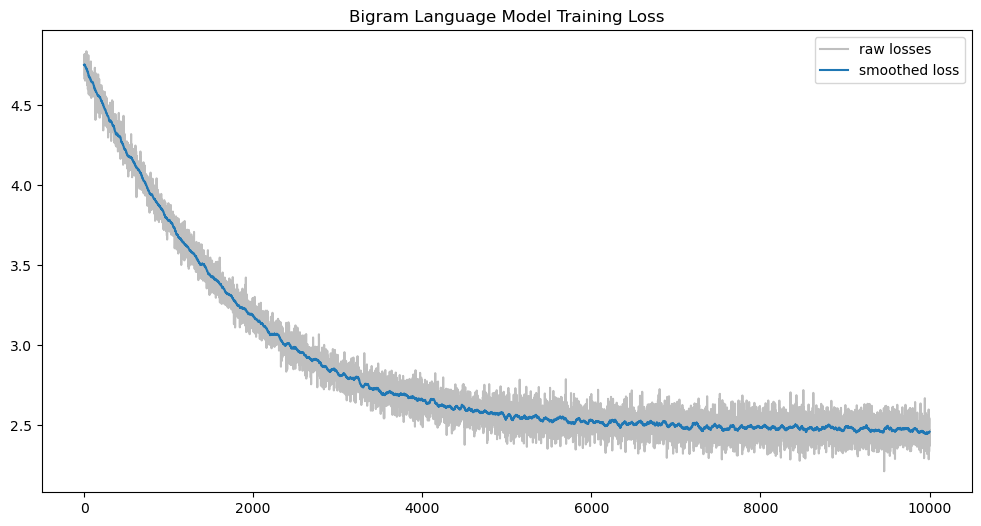

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 平滑 loss 并可视化
def smooth(x, window=50):
    pad_width = window // 2
    x = np.pad(x, pad_width=pad_width, mode='edge')
    return np.convolve(x, np.ones(window), 'valid') / window  # numpy 的卷积函数， same 存在边界问题，valid 会缩短长度
train_losses = np.array(losses)
smoothed_losses = smooth(train_losses)
# variance = np.var(train_losses)  # 这个方差不是很有意义，计算了所有时间全局的方差

plt.figure(figsize=(12, 6))
plt.plot(train_losses, color='grey', alpha=0.5, label='raw losses')
plt.plot(smoothed_losses, label='smoothed loss')
# plt.fill_between(range(len(train_losses)), smoothed_losses-variance, smoothed_losses+variance, color='blue', alpha=0.2)
plt.legend()
plt.title('Bigram Language Model Training Loss')

In [51]:
print(decode(m.generate(idx = torch.ones((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))  # 从空白开始生成

 sy atsomo clour pad d wikn h,
HYy my Tholes:
it GBy ke m vilou xthazinderand llo chee lond Cld this lisesule wars, tirofof wnofan
Rou cthe p.

By hat celis ire m, aksthethe aur withAR wotoot.
Toy:me, of Ithed; bo r:
DWAy celowinoourne, lfonthavelller:f fowhilong bert irw:
I m;
ADWhit hor hy t I nd, billexve, war t, s
When re llyong thm ithinde!


Am mire ow
MIAPet mad, trd br tha
ANG w t we illlaisthe:
CESk ewhaiowaue e;I'OND:
t m; br
Fergho br rosoulin rfe.

Lnoof bl, bald woande: ay,
LABRKitir


### ↑ 至此，整理到 Python 脚本中

# Self-Attention

In [46]:
# 目的：make tokens communicate with each other, but only with previous token (because we are trying to predict the future)
# now, we just use the average of the previous tokens, which is very lossy

## The mathematical trick in self-attention
所谓 trick，主要是用矩阵的方式来并行实现一些平均的操作，而不是直接用 for 循环  
体现在下文两种 xbow 的实现方法

In [51]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))  # 下三角矩阵，用来做后续的加权平均权重
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [50]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [52]:
# bow 是 bag of words 的缩写
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [57]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))  # short for weight, 构造一个下三角矩阵，这样每个 token 都可以看到之前的所有 token 的均值
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)  wei 本身是 (T, T), 但是 torch 会自动 broadcast
# ↑ use batched matrix multiply to do aggregation
torch.allclose(xbow, xbow2)  # 说明代码没写错

True

In [ ]:
# version 3: use Softmax 第三种写法
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))  # 这种做法的好处是，保留了一种 affinities between tokens，token 之间的权重可以 be data-dependent
wei = wei.masked_fill(tril == 0, float('-inf'))  # 除去下三角的部分，其他部分填充为负无穷 -> 意味着 token 无法看到未来的 token
wei = F.softmax(wei, dim=-1)  # 类似于一种标准化, 因为 e^0 = 1, e^(-inf) = 0
xbow3 = wei @ x
torch.allclose(xbow, xbow3)